In [1]:
import os
import sys
import pickle
import numpy as np
import essentia.standard as ess
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd
import json

In [2]:
#Container for analysis parameters
class AnalysisParams:
    def __init__(self,windowSize,hopSize,windowFunction,fftN,fs):
        '''
        windowSize: milliseconds,
        hopSize: milliseconds,
        windowFunction: str ('blackman','hanning',...)
        fftN: int
        '''
        self.windowSize = windowSize
        self.hopSize = hopSize
        self.windowFunction = windowFunction
        self.fftN=fftN
        self.fs=fs

def initiateData4File(file,root):
    '''Forming the data structure for file
    Parameters
    ----------
    file,root : str
        File name and path info
    
    Returns
    -------
    fileData : dict
        Dictionary containing all info and data for the file
    ''' 
    fileData=dict();fileData['name']=file.split('.')[0];fileData['path']=root;
    #Tonal features
    fileData['hpcp']=[];
    fileData['mean_hpcp_vector']=[];
    #data from annotations
    fileData['groundtruth']=[];
    fileData['key']=[];
    fileData['tuning']=[];
    
    return fileData

In [144]:
def sliceAudiotoParts(audio,endTime,startTime,params): #slicing the audio into parts according to annotated timestamps
    fs = params.fs
    endtime=float(endTime)
    starttime=float(startTime)
    audio_slice = audio[starttime*fs:endtime*fs]
    return audio_slice

def computeReferenceFrequency(tonic,tuningfreq):    #computation of the reference frequency for HPCP vector from the tonic of the audio segment
    keys = {'A':0,'Bb':1,'B':2,'C':3,'C#':4,'D':5,'Eb':6,'E':7,'F':8,'F#':9,'G':10,'G#':11}
    for key in keys:
        if key == tonic:
            ref_freq = tuningfreq * (2**((keys[key]*100)/1200)) /2 #compute reference frequency according to the key (tonic) of the audio file
                                                     #divide the results by 2 the get one octave lower pitch as the reference freq
            return ref_freq
        
def computeHPCP(x,windowSize,hopSize,params):   
    
    #Initializing lists for features
    hpcp=[];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize=windowSize, hopSize=hopSize, startFromZero=True):
        frame=ess.Windowing(size=windowSize, type=params.windowFunction)(frame)
        mX = ess.Spectrum(size=windowSize)(frame)
        mX[mX<np.finfo(float).eps]=np.finfo(float).eps
        
        freq,mag = ess.SpectralPeaks()(mX) #extract frequency and magnitude information by finding the spectral peaks
        tunefreq, tunecents = ess.TuningFrequency()(freq,mag)
        reffreq = computeReferenceFrequency(fileData['key'][0],tunefreq)
        hpcp.append(ess.HPCP(normalized='unitSum',referenceFrequency=reffreq)(freq,mag)) #harmonic pitch-class profiles 
        
    return hpcp, tunefreq

def computeHPCPFeatures(fileData,params):
    '''Computation of the low-level features
    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    params : instance of AnalysisParams
        Analysis parameters
    Modifies
    -------
    fileData 
    '''
    #Reading the wave file
    fs=params.fs
    x = ess.MonoLoader(filename = os.path.join('../audio/', fileData['name']+'.aiff'), sampleRate = fs)()
    x = ess.DCRemoval()(x) ##preprocessing / apply DC removal for noisy regions
    x = ess.EqualLoudness()(x)
    #Windowing (first converting from msec to number of samples)
    windowSize=round(fs*params.windowSize/1000);windowSize=int(windowSize/2)*2#assuring window size is even
    hopSize=round(fs*params.hopSize/1000);hopSize=int(hopSize/2)*2#assuring hopSize is even
    
    #slicing audio
    startTime=fileData['groundtruth']['startTime']
    endTime=fileData['groundtruth']['endTime']
    x_slice = sliceAudiotoParts(x,endTime,startTime,params)
    
    HPCPs, tuningfreq = computeHPCP(x_slice,windowSize,hopSize,params)
    fileData['hpcp']=np.array(HPCPs);
    fileData['tuning'] = tuningfreq;
    
def computeGlobHPCP(fileData):
    '''Computation of the global features from low-level features
    An energy threshold (NRGthres*maxEnergy) is applied to exclude features from silence regions

    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    NRGthresPerc: float
        Energy threshold defined as ratio to maximum energy. Ex: 0.05 corresponds to 5%
    Modifies
    -------
    fileData 
    '''
    
    features=list(fileData.keys())
    features.remove('path');features.remove('name')
    for feature in features:
        if feature == 'hpcp':
            for j in range(12):
                hpcps = [];
                for i in range(len(fileData['hpcp'])):
                    hpcps.append(fileData['hpcp'][i][j])
                fileData['mean_hpcp_vector'].append(np.mean(hpcps))                
       
    for l in range(12):
        ind=str(l)
        fileData['mean_hpcp'+ind]=fileData['mean_hpcp_vector'][l]    

In [145]:
targetDir='../scale_new/'
params=AnalysisParams(30,10,'hann',2048,44100)

dataDict=dict()
for root, dirs, files in os.walk(targetDir):
    for file in files:
        if file.endswith('.json'):
            with open(targetDir+file) as json_file:
                annotationData=json.load(json_file)
                fileName=file.split('.')[0]
                dataParts=annotationData['parts']
                for i in range (len(dataParts)):
                    
                    fileData=initiateData4File(file,root)            
                    files4scale=dataDict.get(fileName)
                    if files4scale==None:
                        files4scale=[fileData]
                    else:
                        files4scale.append(fileData)
                    
                    dataDict[fileName]=files4scale
                    dataDict[fileName][i]['groundtruth']=dataParts[i]
                    dataDict[fileName][i]['key']=annotationData['sandbox']['key']
dataDict  

{'aebersold_dorian': [{'groundtruth': {'endTime': '15.72',
    'name': 'Part1',
    'scaleType': 'Bb:dorian',
    'startTime': '3.62'},
   'hpcp': [],
   'key': ['Bb'],
   'mean_hpcp_vector': [],
   'name': 'aebersold_dorian',
   'path': '../scale_new/'},
  {'groundtruth': {'endTime': '37.797',
    'name': 'Part2',
    'scaleType': 'Bb:dorian',
    'startTime': '17.23'},
   'hpcp': [],
   'key': ['Bb'],
   'mean_hpcp_vector': [],
   'name': 'aebersold_dorian',
   'path': '../scale_new/'},
  {'groundtruth': {'endTime': '60.07',
    'name': 'Part3',
    'scaleType': 'Bb:dorian',
    'startTime': '38.50'},
   'hpcp': [],
   'key': ['Bb'],
   'mean_hpcp_vector': [],
   'name': 'aebersold_dorian',
   'path': '../scale_new/'},
  {'groundtruth': {'endTime': '87.08',
    'name': 'Part4',
    'scaleType': 'Bb:dorian',
    'startTime': '60.77'},
   'hpcp': [],
   'key': ['Bb'],
   'mean_hpcp_vector': [],
   'name': 'aebersold_dorian',
   'path': '../scale_new/'},
  {'groundtruth': {'endTime': '1

In [146]:
#Feature Extraction
print('Tracks in the dataset')

for fileName,parts in dataDict.items():
    print(fileName)
    for part in parts:
        computeHPCPFeatures(part,params)
        computeGlobHPCP(part)

#Saving all results in a pickle file

pickleProtocol=1#choosen for backward compatibility
with open(targetDir+'extractedfeatures.pkl' , 'wb') as f:
    pickle.dump(dataDict, f, pickleProtocol)

#Let's clear data and re-read it
print('Features extracted and saved in a file')        

hikmet_hwdiminished
hikmet_lydian
toprak_phyrgian
toprak_hminor
toprak_locrian
hikmet_dorian
toprak_lydian1
aebersold_phyrgian
aebersold_minor
hikmet_lydianb7
toprak_major1
hikmet_dorian1
toprak_major2
toprak_locrian#21
toprak_minor
hikmet_minor1
toprak_major3
toprak_dorian1
hikmet_hminor2
aebersold_locrian
aebersold_dorian
toprak_major
hikmet_locrian
aebersold_lydianb7
toprak_mixolydian
toprak_locrian1
toprak_hminor1
toprak_phyrgian1
hikmet_mixolydian
toprak_lydianb7
hikmet_hminor1
toprak_lydianb71
hikmet_lydianb71
toprak_locrian#2
hikmet_major
aebersold_major
hikmet_phyrgian
toprak_minor1
toprak_dorian
hikmet_locrian#2
toprak_lydian
toprak_hwdiminished
hikmet_hminor
hikmet_locrian1
hikmet_minor
Features extracted and saved in a file


In [147]:
#Plotting & Visualization
scales=['major','dorian','phyrgian','lydian','mixolydian','minor','locrian','lydianb7','locrian#2','hwdiminished','hminor']
print('Scales in this dataset: ',scales)

allparts=[]
HPCPscales=dict()#dictionary including dictionaries scale->feature->data
scale = 'lydian' #choose explicitly which scale to visualize (TODO for automatically)
for scale in scales:
    for fileName, parts in dataDict.items():
        if fileName.find(scale) != -1:
            for part in parts:
                scaletype = part['groundtruth']['scaleType'].split(':')[1]
                if scaletype == scale: #if scale matches with ground truth
                                       #put them in the same container
                    filescale=HPCPscales.get(scale)
                    
                    if filescale==None:
                        filescale=[part['mean_hpcp_vector']]
                    else:
                        filescale.append(part['mean_hpcp_vector'])
                    
                    HPCPscales[scale]=filescale
                allparts.append(fileName)        
            

Scales in this dataset:  ['major', 'dorian', 'phyrgian', 'lydian', 'mixolydian', 'minor', 'locrian', 'lydianb7', 'locrian#2', 'hwdiminished', 'hminor']


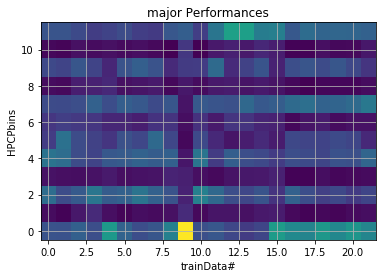

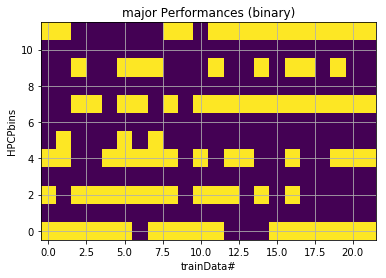

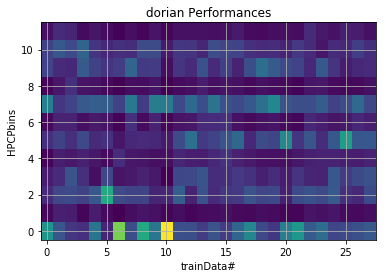

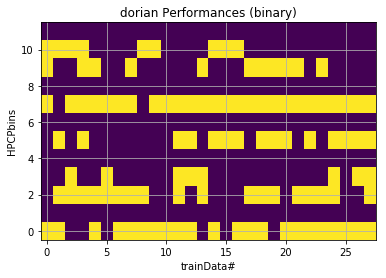

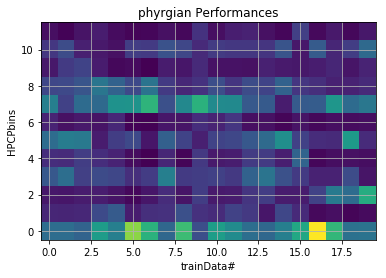

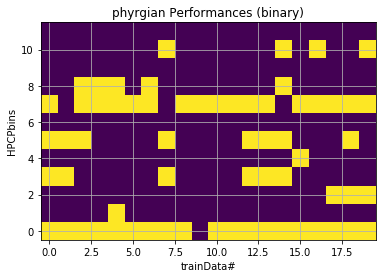

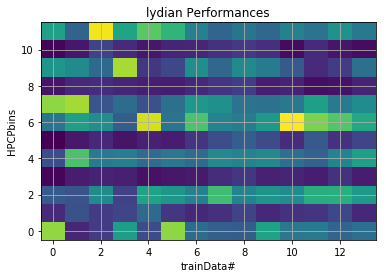

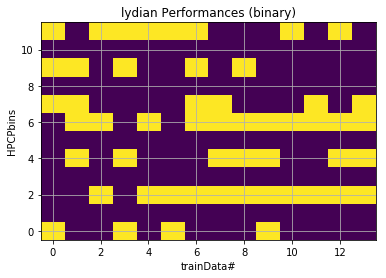

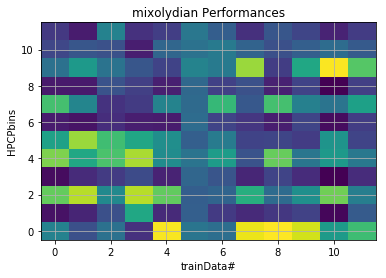

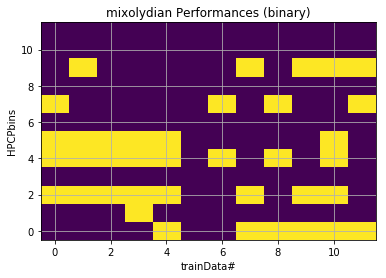

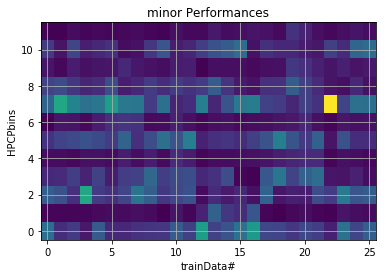

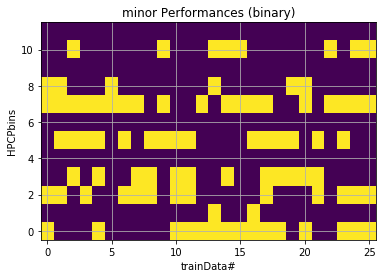

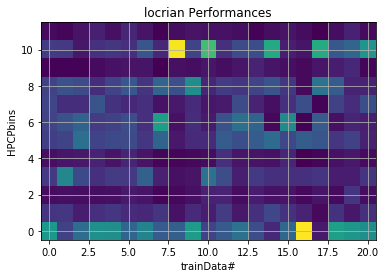

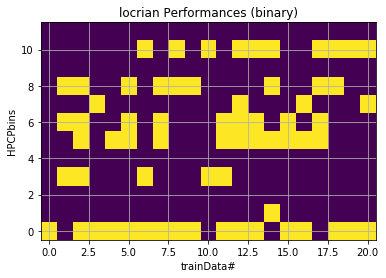

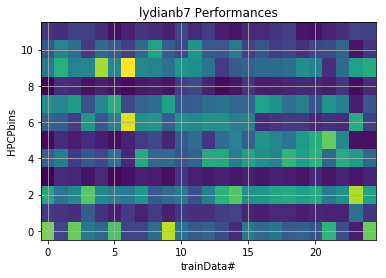

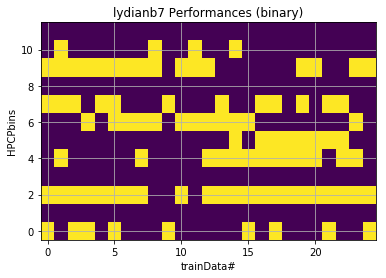

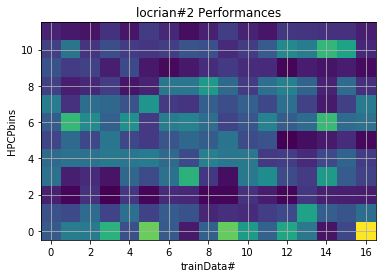

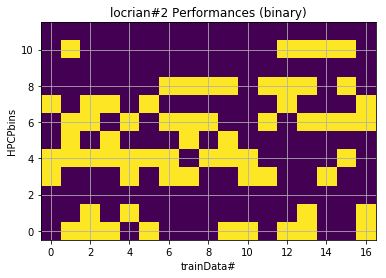

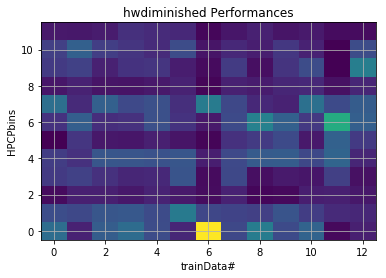

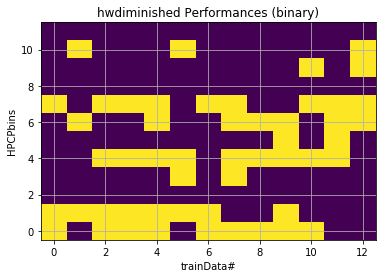

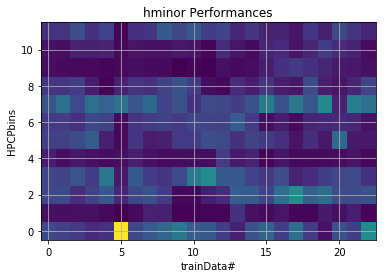

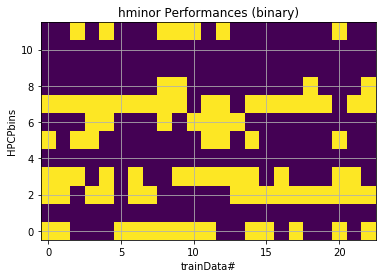

In [162]:
imagenumber=1
for scale in scales:
    hpcparray=[];
    for i in range(len(HPCPscales[scale])):
        hpcparray.append(HPCPscales[scale][i])
    globalhpcparray=np.array(hpcparray)
    temp=globalhpcparray.transpose()
    plt.figure(imagenumber)
    plt.imshow(temp, interpolation='nearest',origin='lower')
    plt.title(scale +' Performances')
    plt.ylabel('HPCPbins')
    plt.xlabel('trainData#')
    plt.axis('tight') 
    plt.grid(True)
    plt.show()

    imagenumber = imagenumber+1
    bin_representation=[];
    for j in range(len(globalhpcparray)):
        bin_representation.append(np.where(globalhpcparray[j]>0.105,1,0))#TODO parametric
    
    bin_plot = np.array(bin_representation)
    temp1=bin_plot.transpose()
    plt.figure(imagenumber)
    plt.imshow(temp1, interpolation='nearest',shape=(12,5),origin='lower')
    plt.title(scale +' Performances (binary)')
    plt.ylabel('HPCPbins')
    plt.xlabel('trainData#')
    plt.axis('tight')
    plt.grid(True)
    plt.show()
    
    imagenumber = imagenumber + 1


In [51]:
from sklearn.model_selection import KFold    # K-Fold cross validation - 302 datapoints
kf = KFold(n_splits=10,shuffle=True)         # K = 10
kf.get_n_splits(dataDict)
train_list=[];test_list=[];
for train_index, test_index in kf.split(dataDict):
    print("TRAIN:", train_index, "TEST:", test_index)
    
    

TRAIN: [ 0  2  3  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44] TEST: [ 1  4  8 28 33]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 33 34 35 36 37 40 41 42 43 44] TEST: [ 0 12 32 38 39]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 16 17 19 20 21 22 23 25 26 27 28
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] TEST: [ 6 15 18 24 29]
TRAIN: [ 0  1  2  3  4  5  6  8  9 11 12 13 14 15 16 17 18 20 21 22 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44] TEST: [ 7 10 19 23 43]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 31 32 33 34 35 37 38 39 41 42 43] TEST: [ 9 30 36 40 44]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 15 16 17 18 19 21 22 23 24 25 26 27
 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44] TEST: [13 14 20 31]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 26 27